# SP500 data 
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr> 

In [106]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('/volper/users/alayaelm/Documents/git/wasslsp/src/')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = '/volper/users/alayaelm/Documents/git/wasslsp/data/'


In [107]:
df_sp500 = pd.read_csv(path_data + 'sp500_data.csv')

In [108]:
df_sp500.shape, 

((8372, 5),)

In [109]:
df_sp500.head()

,Date,SP500,T10yAaa.lag,AaaBaa.lag,T10yT1y.lag
0,1986-01-03,0.006136,0.88,1.46,1.40
1,1986-01-06,-0.001091,0.87,1.43,1.40
2,1986-01-07,0.014843,0.87,1.42,1.43
3,1986-01-08,-0.027647,0.91,1.44,1.35
4,1986-01-09,-0.008984,0.76,1.45,1.40


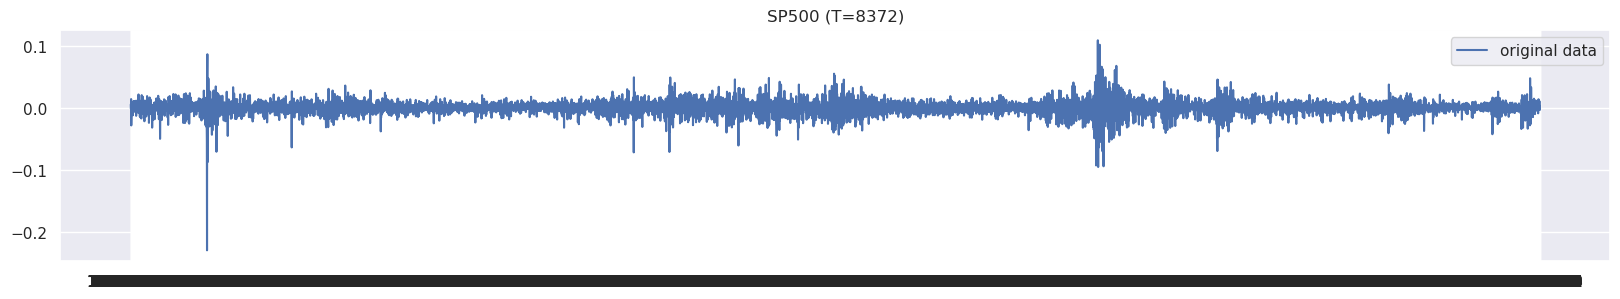

In [110]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_sp500['Date'], df_sp500['SP500'], label="original data")
# plt.plot(df_sp500['Date'], df_sp500['SP500'].diff(), label="diff")
plt.legend()
plt.title("SP500 (T=8372)")
plt.show()

In [111]:
dates = df_sp500['Date'].copy()
dates = pd.to_datetime(dates, format="%Y-%m-%d")

In [112]:
T = df_sp500.shape[0]
d = 1

In [113]:
def replication_SP500(data=None, sigma=1., d=1, n_replications=1):
    """
    Replication genearating procedure of SP500 data
    """
    T = data.shape[0]
    
    X_tvar_2 = np.zeros(T)
    X_tvar_2_replications = np.zeros((n_replications, T))

    X_dict = {}
    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T), scale=sigma)
        X = np.zeros((T,d))
        while t <= T-1 :
            X_tvar_2[t] = df_sp500['SP500'].values[t] + epsilon[t]
            X[t] = [X_tvar_2[t-1]]
            t += 1
        
        X_dict[str(replication)] = X
        X_tvar_2_replications[replication] = X_tvar_2
        
    return X_tvar_2_replications

In [114]:
sns.set(style="darkgrid")

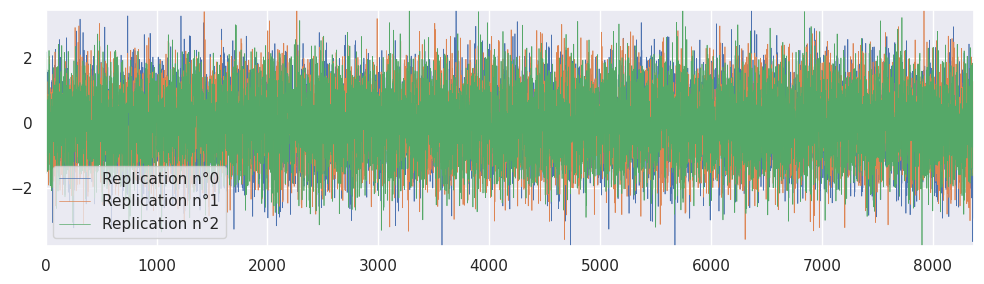

In [115]:
plt.rcParams["figure.figsize"] = (10,3)

T = df_sp500.shape[0]
u_var = np.linspace(0., 1., T)
sigma = 1.
n_replications = 3

X_tvar_2_replications = replication_SP500(
    data=df_sp500['SP500'], sigma=sigma, n_replications=n_replications
)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=.5, label='Replication n°' f'{replication}')
    plt.ylim(min(X_tvar_2_replications[replication]), max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    
    plt.grid(True)
    plt.legend()
    
plt.tight_layout()
plt.savefig(f"3 replications of SP500 dataset sigma={sigma}.pdf", dpi=300)
plt.show()

# NW Conditional CDF

In [116]:
times_t = [2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500]
times_T = [T]
times_sigma = [1, 0.1, 0.01, 0.001, 0.0001]
n_replications = [1000, 1500, 2000]
d = 1


In [117]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

for sigma_ in times_sigma:
    X_dict[f"sigma:{sigma_}"] = {}
    
    for rep in n_replications:
        X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
        X_dict[f"sigma:{sigma_}_rep:{rep}"] = {}


In [118]:
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [119]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                t = 1
                epsilon = np.random.normal(size=T, scale=sigma_)
                X = np.zeros((T, d))
                X_tvar_2_T = np.zeros(T)
                
                while t <= T-1:
                    X_tvar_2_T[t] = df_sp500['SP500'].values[t] + epsilon[t]
                    X[t] = [X_tvar_2_T[t-1]]
                    t += 1

                X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication] = X_tvar_2_T
                X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)] = X


In [120]:
X_tvar_2 = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


In [121]:

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for rep in n_replications:
        for replication in range(rep):
            for sigma_ in times_sigma:
                z = X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication][t-1]
                X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(z)


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.array(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [122]:
plt.rcParams["figure.figsize"] = (5, 4)

norm_X_tvar_2 = {}
for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            norm_X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


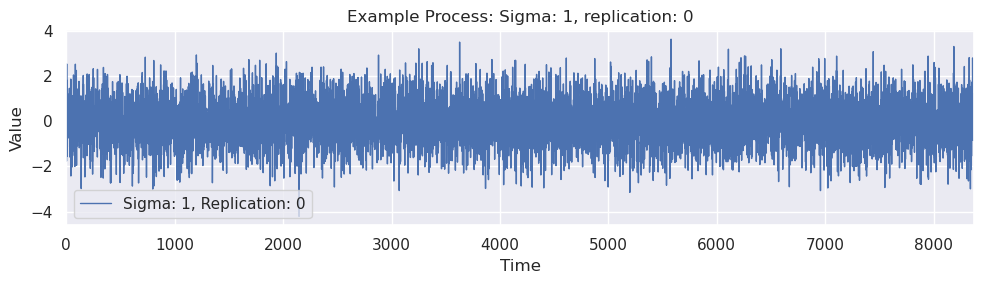

In [123]:
sigma_example = times_sigma[0]  
rep_example = n_replications[0]  

example_process_key = f"sigma:{sigma_example}_rep:{rep_example}"
example_replication = "0"  

time_series = X_dict[example_process_key][example_replication]

plt.rcParams["figure.figsize"] = (10,3)
plt.plot(time_series, label=f"Sigma: {sigma_example}, Replication: {example_replication}", lw=1)
plt.title(f"Example Process: Sigma: {sigma_example}, replication: {example_replication}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(0, T)
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# space_kernel = "gaussian"; time_kernel = "uniform"

In [124]:
space_kernel = "gaussian"  # "silverman"
time_kernel = "uniform"  # "tricube"
xi = 0.4 / (2 * (d + 1))
lambda_ = 1 / 12

T = df_sp500.shape[0]
gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}

for sigma_ in times_sigma:
    bandwidth = lambda_ * (T ** (-xi))
    gaussian_kernel[f"sigma:{sigma_}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)


In [125]:
gaussian_kernel

{'sigma:1': Kernel(T=8372, bandwidth=0.03377037101411927, time_kernel='uniform'),
 'sigma:0.1': Kernel(T=8372, bandwidth=0.03377037101411927, time_kernel='uniform'),
 'sigma:0.01': Kernel(T=8372, bandwidth=0.03377037101411927, time_kernel='uniform'),
 'sigma:0.001': Kernel(T=8372, bandwidth=0.03377037101411927, time_kernel='uniform'),
 'sigma:0.0001': Kernel(T=8372, bandwidth=0.03377037101411927, time_kernel='uniform')}

In [126]:
for rep in n_replications:
    for replication in range(rep):
        for t in times_t:
            for sigma_ in times_sigma:
                gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = \
                gaussian_kernel[f"sigma:{sigma_}"].fit(X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)], t)


In [127]:
n_replications

[1000, 1500, 2000]

In [128]:
gaussian_weights_tensor = {}  

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):
        for rep in n_replications:
            gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"] = {}

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):  
        for rep in n_replications:
            for replication in range(rep):
                # Assign the corresponding gaussian weights for each replication and rep
                gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)] = \
                gaussian_weights[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)]


In [129]:
empirical_cds = {}

# norm_X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"]
for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [130]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [131]:
x_rep = {} 
y_rep = {} 
wasserstein_distances = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


for rep in n_replications:
    for replication in range(rep): 
        for t in times_t:
            for sigma_ in times_sigma:
                y, x = eval_univariate(
                    X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication], 
                    gaussian_weights_tensor[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )
                
                x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = x    
                y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = y
                
                distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication]))
                wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = distance


# Calculus of Wasserstein distance between means of NW estimators and mean of empirical CDFs

In [177]:

wass_distances_all_replications = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                
                wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(
                    wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )


In [133]:
plt.rcParams["figure.figsize"] = (10, 3)
wass_distances_empirical_meanNW = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            
            wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = wasserstein_distance(
                empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"], y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"].mean(axis=0)
            )


In [134]:
wass_distances_empirical_meanNW

{'t:2750_sigma:1_rep:1000': np.float64(0.02133441779074613),
 't:2750_sigma:1_rep:1500': np.float64(0.008442644163768453),
 't:2750_sigma:1_rep:2000': np.float64(0.004595045589072792),
 't:2750_sigma:0.1_rep:1000': np.float64(0.21956685827323005),
 't:2750_sigma:0.1_rep:1500': np.float64(0.21888041520684431),
 't:2750_sigma:0.1_rep:2000': np.float64(0.21846068359141313),
 't:2750_sigma:0.01_rep:1000': np.float64(0.25425569684913757),
 't:2750_sigma:0.01_rep:1500': np.float64(0.25426341235981925),
 't:2750_sigma:0.01_rep:2000': np.float64(0.25438404124823577),
 't:2750_sigma:0.001_rep:1000': np.float64(0.25039386339234476),
 't:2750_sigma:0.001_rep:1500': np.float64(0.25046474332460145),
 't:2750_sigma:0.001_rep:2000': np.float64(0.2504280326657571),
 't:2750_sigma:0.0001_rep:1000': np.float64(0.24925333861295706),
 't:2750_sigma:0.0001_rep:1500': np.float64(0.24924890131835384),
 't:2750_sigma:0.0001_rep:2000': np.float64(0.24925244479313458),
 't:3000_sigma:1_rep:1000': np.float64(0.0

In [135]:
wass_times_t = {}
for t in times_t:
    for rep in n_replications:
        wass_times_t[f"t:{t}_rep:{rep}"] = []
        for sigma_ in times_sigma:
            key = f"t:{t}_sigma:{sigma_}_rep:{rep}"
            distance = wass_distances_empirical_meanNW.get(key, 0)
            wass_times_t[f"t:{t}_rep:{rep}"].append(distance)


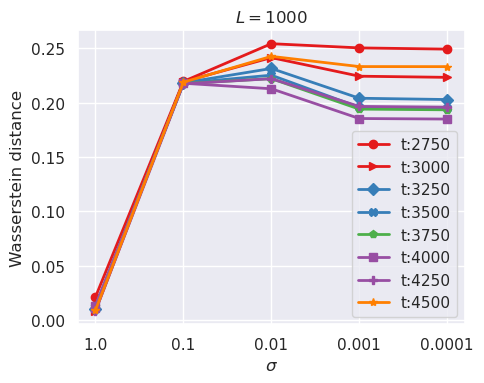

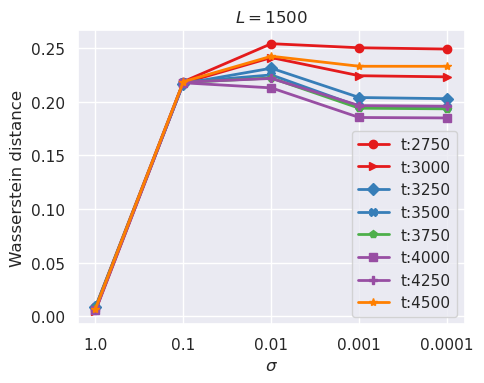

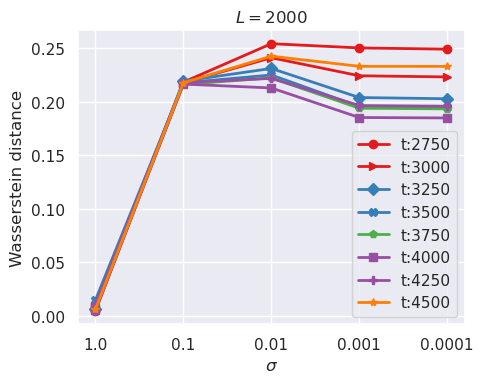

In [168]:

plt.rcParams["figure.figsize"] = (5, 4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*']
times_sigma_cat = [r'1.0', r'0.1', r'0.01', r'0.001', r'0.0001']
#times_sigma_inv_cat = [f'${1/sigma:.2f}$' for sigma in times_sigma]

for rep in n_replications:
    plt.figure()
    for i, t in enumerate(times_t):
        plt.plot(times_sigma_cat, wass_times_t[f"t:{t}_rep:{rep}"], label=f"t:{t}", color=colors[i % len(colors)], marker=markers[i % len(markers)], markersize=6, lw=2)

    # y_ticks = np.linspace(0.05, 0.9, 6)
    # plt.yticks(y_ticks)
    plt.xlabel(r'$\sigma$')
    plt.ylabel("Wasserstein distance")
    plt.title(f"$L = {rep}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"W1_SP500_time-uniform_space-gaussian_rep_{rep}.png", dpi=150)
    plt.show()


In [142]:
t = times_t[5]
rep = 2000
wass_times_t[f"t:{t}_rep:{rep}"]

[np.float64(0.005142879430822606),
 np.float64(0.21662465082130133),
 np.float64(0.21299505283552303),
 np.float64(0.18537738457471453),
 np.float64(0.18497822378715728)]

In [174]:
sigmas = np.array(times_sigma)
np.flip(sigmas)[:-1]

array([0.0001, 0.001 , 0.01  , 0.1   ])

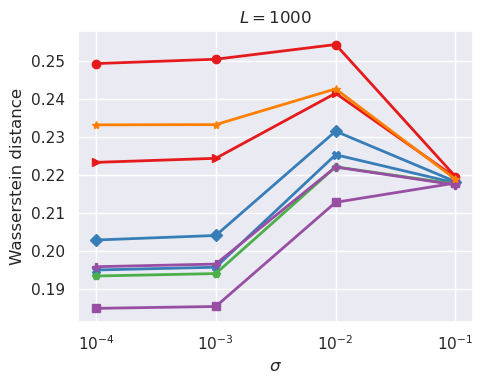

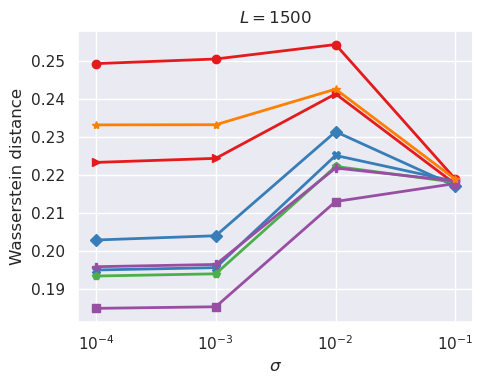

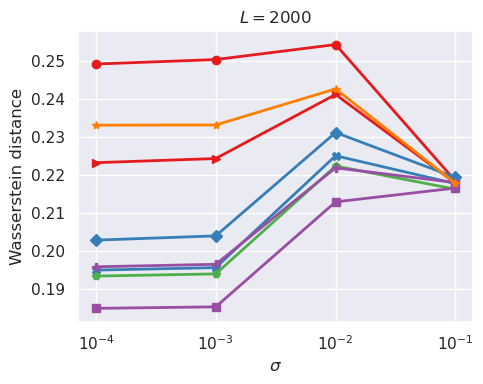

In [176]:

plt.rcParams["figure.figsize"] = (5, 4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*']
times_sigma_cat = [r'1.0', r'0.1', r'0.01', r'0.001', r'0.0001']
#times_sigma_inv_cat = [f'${1/sigma:.2f}$' for sigma in times_sigma]

sigmas = np.array(times_sigma)

for rep in n_replications:
    plt.figure()
    for i, t in enumerate(times_t):
        plt.plot(np.flip(sigmas)[:-1], np.flip(wass_times_t[f"t:{t}_rep:{rep}"])[:-1], label=f"t:{t}", color=colors[i % len(colors)], marker=markers[i % len(markers)], markersize=6, lw=2)

    # y_ticks = np.linspace(0.05, 0.9, 6)
    # plt.yticks(y_ticks)
    plt.xscale("log")
    plt.xlabel(r'$\sigma$')
    plt.ylabel("Wasserstein distance")
    plt.title(f"$L = {rep}$")
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"W1_SP500_time-uniform_space-gaussian_rep_{rep}_flip_sigmas.png", dpi=150)
    plt.show()